In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import pandas as pd
import numpy as np
import json
from datetime import date, datetime
import logging
from elastic_util import *
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
logger = logging.getLogger('psychosis_risk_cal')
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s : %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# 1. Read test data

In [3]:
test_df = pd.read_excel('data/test_data.xlsx')

In [18]:
test_df.shape

(120, 55)

# 1.1 Original calculation is only for patients whose ages are large than 16

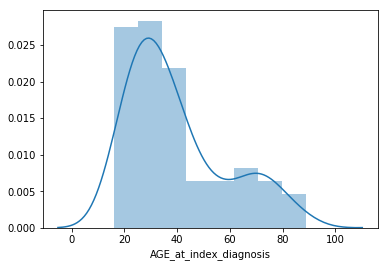

In [5]:
sns.distplot(test_df['AGE_at_index_diagnosis'])
plt.show()

In [6]:
min(test_df['AGE_at_index_diagnosis'])

16

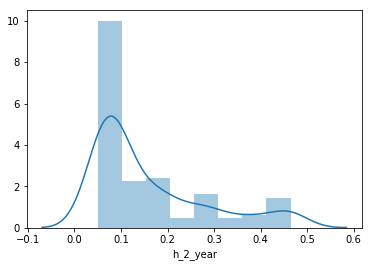

In [7]:
sns.distplot(test_df['h_2_year'])
plt.show()

# 2. Read data from Cogstack

In [8]:
logger.info('Connect to host.....')
client = Elasticsearch(['http://10.16.31.65:9200/'], request_timeout=600)
doc_type='doc'
index = 'psychosis_risk'
s = Search(using=client, index=index, doc_type=doc_type).filter('range', h_2_year={'gte': 0.05})
logger.info('Loaded %s documents' %s.count())
df = pd.DataFrame((d.to_dict() for d in s.scan()))
logger.info('Documents shape: %s %s' %(df.shape))

logger.info('Change data types')
#     df['first_primary_diagnosis_date'] = pd.to_datetime(df['first_primary_diagnosis_date'])
#     df['patient_date_of_birth'] = pd.to_datetime(df['patient_date_of_birth'])
#     df['first_primary_diagnosis_recorded_date'] = pd.to_datetime(df['first_primary_diagnosis_recorded_date'])
#     print(df.dtypes)
#     df['patient_id'] = df['patient_id'].astype(int)
#     df['referral_id'] = df['referral_id'].astype(int)
logger.info('Documents shape after changing data types: %s %s' %(df.shape))

2019-05-13 14:43:34,055 psychosis_risk_cal INFO     : Connect to host.....
2019-05-13 14:43:34,064 psychosis_risk_cal INFO     : Loaded 6963 documents
2019-05-13 14:43:34,752 psychosis_risk_cal INFO     : Documents shape: 6963 34
2019-05-13 14:43:34,753 psychosis_risk_cal INFO     : Change data types
2019-05-13 14:43:34,755 psychosis_risk_cal INFO     : Documents shape after changing data types: 6963 34


In [9]:
df.shape

(6963, 34)

# 3. Records missed in Cogstack

In [10]:
set(test_df['Other_ID1']) - set(df['patient_other_id1'])

{datetime.datetime(1943, 1, 24, 0, 0),
 datetime.datetime(1998, 1, 24, 0, 0),
 '59-64-19',
 '61-27-69'}

## There are 4 records are missed in Cogstack, 

## where 2 have mistakes in Other_ID1, so these 2 records cannot be tracked back.

## Reason for the other 2 missed records (i.e., patients with "Other_ID1" of '59-64-19' and '61-27-69'): 

## Original calculation did not exclude invalid diagnosis, see the "index_primary_diagnosis" filed in the Excel file. The "index_primary_diagnosis" of these patients in the Excel file are "F31.3 - Bipolar affect disorder cur epi mild or moderate depression" and "F30.1 - Mania without psychotic symptoms", the same as the Primary_Diag of these patients' invalid diagnoses.

## Below is the diagnoses of these two patients from ePJS. The first Primary_Diag of these two patients are invalid, so they are excluded in Cogstack-based calculations.

|Patient_ID|Other_ID1|
|----------|---------|
|471259|59-64-19|


|ICD10_ID|Patient_ID|Diagnosis_Date|Created_Date|dnum|Primary_Diag|Invalid_Flag_ID|Invalid_Date|Invalid_Reason|
|--------|----------|--------------|------------|----|------------|---------------|------------|--------------|
|833975|471259|2018-03-19|2018-03-19|1|F31.3 - Bipolar affect disorder cur epi mild or moderate depression|1|2018-04-10 00:00:00|Wrong diagnosis entered erroneously |
|837500|471259|2018-04-10|2018-04-10|2|F32.1 - Moderate depressive episode|0|||
|862940|471259|2018-08-28|2018-08-28|3|F33.4 - Recurrent depressive disorder, currently in remission|0|||



|Patient_ID|Other_ID1|
|----------|---------|
|487618|61-27-69|


|ICD10_ID|Patient_ID|Diagnosis_Date|Created_Date|dnum|Primary_Diag|Invalid_Flag_ID|Invalid_Date|Invalid_Reason|
|--------|----------|--------------|------------|----|------------|---------------|------------|--------------|
|875441|487618|2018-11-09|2018-11-09|1|F30.1 - Mania without psychotic symptoms|1|2018-11-09 00:00:00||
|875442|487618|2018-11-09|2018-11-09|2|F30.2 - Mania with psychotic symptoms|0|||
|882163|487618|2018-12-12|2018-12-12|3|F30.2 - Mania with psychotic symptoms|0|||
|887016|487618|2019-01-12|2019-01-12|4|F30.2 - Mania with psychotic symptoms|0|||
|888452|487618|2019-01-21|2019-01-21|5|F30.2 - Mania with psychotic symptoms|0|||
|889448|487618|2019-01-25|2019-01-25|6|F30.2 - Mania with psychotic symptoms|0|||
|890244|487618|2019-01-30|2019-01-30|7|F30.2 - Mania with psychotic symptoms|0|||
|890914|487618|2019-01-30|2019-02-02|8|F30.2 - Mania with psychotic symptoms|0|||



# 4. Check differences of risk scores

In [11]:
common_ids = set(test_df['Other_ID1']).intersection(set(df['patient_other_id1']))

In [12]:
len(common_ids)

116

In [13]:
orig_fields = ['Gender_co_ef', 'Age_co_ef', 'diagnosis_group_co_ef', 'Eth_co_ef', 'GenderAge']
cog_fields = ['gender_coeff', 'age_coeff', 'diagnosis_group_coeff', 'eth_coeff', 'gender_age_coeff']
flen = len(orig_fields)

## 4.1 Check different of PI

In [14]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['PI'].values[0]
    cog = df[df['patient_other_id1'] == id]['PI'].values[0]
    if abs(orig - cog) > 0.00001:
        mis_count += 1
        print(str(id) + ' is different on PI values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.00001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

49-70-14 is different on PI values: 1.5722854   1.5308083000000001
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
56-85-16 is different on PI values: 0.5606118   0.1525082
	eth_coeff is different:  0.4081036   0.0
2


|patient_id|patient_updated_dttm|patient_name|patient_other_id1|patient_date_of_birth|patient_demography_gender|patient_demography_ethnicity|
|----------|--------------------|------------|-----------------|---------------------|-------------------------|----------------------------|
|443341|2019-01-02 11:44:32|Ms Alisha Rouse|56-85-16|1990-11-21|Female|British (A)|


|patient_id|patient_updated_dttm|patient_name|patient_other_id1|patient_date_of_birth|patient_demography_gender|patient_demography_ethnicity|
|----------|--------------------|------------|-----------------|---------------------|-------------------------|----------------------------|
|371803|2018-12-04 11:19:35|Mr Adir Ferriera Da Silva|49-70-14|1968-08-30|Male|Portuguese (C4)|


## The above two patients have updates about their demographic information on 2019-01-02 and 2018-12-04, the dates after the dates of original risk calculations, i.e., 29/11/2018 and 28/11/2018 respectively.

## 4.1 Check different of h_2_year

In [16]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['h_2_year'].values[0]
    cog = df[df['patient_other_id1'] == id]['h_2_year'].values[0]
    if abs(orig - cog) > 0.0001:
        mis_count += 1
        print(str(id) + ' is different on h_2_year values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.0001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

49-70-14 is different on h_2_year values: 0.2029   0.1955068031924856
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
56-85-16 is different on h_2_year values: 0.0791   0.0533465597538495
	eth_coeff is different:  0.4081036   0.0
2


## There is no further difference on h_2_year, indicating there is no problem in transforming PI to h_2_year

In [17]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['h_5_year'].values[0]
    cog = df[df['patient_other_id1'] == id]['h_5_year'].values[0]
    if abs(orig - cog) > 0.0001:
        mis_count += 1
        print(str(id) + ' is different on h_5_year values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.0001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

49-70-14 is different on h_5_year values: 0.3447   0.3333470253335954
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
56-85-16 is different on h_5_year values: 0.1425   0.09713753758263477
	eth_coeff is different:  0.4081036   0.0
2


## There is no further difference on h_5_year, indicating there is no problem in transforming PI to h_5_year